# Applied Mathematics 115: Mathematical Modeling  
---
*2024 Spring / Full Term*

**Meeting Time:**  
Tuesday 10:30 AM - 11:45 AM  
Thursday 10:30 AM - 11:45 AM
<br>
<br>

**Instructors:**  
*Michael P. Brenner* (Pierce Hall 313) brenner@seas.harvard.edu  
Francesco Mottes fmottes@seas.harvard.edu  

**Teaching Fellows:**  
Henry Bae henrybae@college.harvard.edu  
Sarah Martinson sarahmartinson@g.harvard.edu  
Shruti Sharma ssharma1@g.harvard.edu  
Al Shodiev alshodiev@college.harvard.edu  
Alex Sullivan alexsullivan@college.harvard.edu  
Matt Tibbitts mtibbitts@college.harvard.edu  


# Lecture 6 Advanced: Racing

This notebook discusses an approach to solving the Keller problem we discussed in class that is an advanced notebook for those who wish to study it. This is not required and the homework problem associated with it is for **extra credit**.  

The first part of the notebook gives an introduction to solving optimization problems for solutions of ODEs in JAX, a modern Machine Learning library with native automatic differentiation.

The second part of the notebook uses JAX to solve the Keller problem.

# Solving and fitting ODE's in JAX

In [1]:
import numpy as np
from jax.experimental.ode import odeint   # JAX's differentiable odeint

import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad, value_and_grad, hessian, jacfwd, jacrev

print("jax version {}".format(jax.__version__))
key = random.PRNGKey(0)

jax version 0.4.23


Consider the following inverse problem: **given data points of $y(x)$, find the parameters of an ODE $\dot{y}(x)=f(x, y)$.**

Fortunately, using `jax.experimental.ode.odeint`, we can


1.   Integrate an ODE
2.   Compare the integrated solution and real data through loss
3.   Take derivatives of the loss w.r.t. ODE parameters or initial conditions (gradient flows through an integrator)
4.   Optimize parameters or initial conditions using gradient descent.

to solve the inverse problem.

## Finding acceleration and initial condition of Newton's law

In this example, the groud truth trajectory is obtained by solving $\dot{y}(t) = 2t$ with an initial condition $y(0) = 0$.

In [2]:
# define ode
def Newton(y, t, a):
    dydt = a*t
    return dydt
# Newton_odeint = odeint(Newton, y, t)

# setup: I.C., ode parameter and t coordinates
y0_real = np.array([0.])  # JAX's odeint expects jax.np.array
a_real = np.array([2.])
t = np.arange(10.)
print("The real acceleration of the object is:", a_real[0])
print("The object starts at y0=",y0_real[0])

# integrate
traj_true = odeint(Newton, y0_real, t, a_real)

The real acceleration of the object is: 2.0
The object starts at y0= 0.0


In [3]:
traj_true

Array([[ 0.       ],
       [ 1.       ],
       [ 3.9999993],
       [ 8.999999 ],
       [15.999997 ],
       [25.       ],
       [36.000008 ],
       [49.       ],
       [63.999996 ],
       [80.99998  ]], dtype=float32)

### Loss and optimization

In [4]:
# MSE loss over trajectory
def loss(a, y0):
    return np.sum((odeint(Newton, y0, t, a).reshape(-1)-traj_true.reshape(-1))**2)

# gradient functions w.r.t. a and y0
dfda = jit(grad(loss, 0))
dfdy0 = jit(grad(loss, 1))

# Guessing y0 and a
y0 = np.array([-0.5])
a = np.array([3.])
print("The initially guessed acceleration is:", a[0])
print("The initially guessed y0 is:", y0[0])

# learning rates
lr_a = 0.00025
lr_y0 = 0.03

# optimization
while np.abs(dfda(a,y0)) > 1e-3 or np.abs(dfdy0(a,y0)) > 1e-3:
    a -= lr_a * dfda(a,y0)
    y0 -= lr_y0 * dfdy0(a,y0)
print("The finally guessed acceleration is:", a[0])
print("The finally guessed y0 is:", y0[0])

The initially guessed acceleration is: 3.0
The initially guessed y0 is: -0.5
The finally guessed acceleration is: 1.999999
The finally guessed y0 is: 1.6670707e-05


Optimized parameter and initial condition match the real values.

## Finding parameters of a pendulum with friction

The second order differential equation for the angle $\theta$ of a pendulum with friction is,

$$ \ddot{\theta}(t) + b\dot{\theta}(t) + c\sin\theta(t)=0$$

To solve the equation of motion numerically, we break it up into a system of two ODEs by introducing the angular velocity $\omega(t)$ to obtain,

$$
\begin{align*}
 \dot{\theta}(t) &= \omega(t) \\
 \dot{\omega}(t) &= -b\omega(t) - c\sin\theta(t)
\end{align*}
$$

In this example, the ground truth trajectories of $\theta$ and $\omega$ are generated using an initial condition of $\theta(0)=\pi-1$ and $\omega(0) = 0$, and parameters $b=0.25$ and $c=5$.

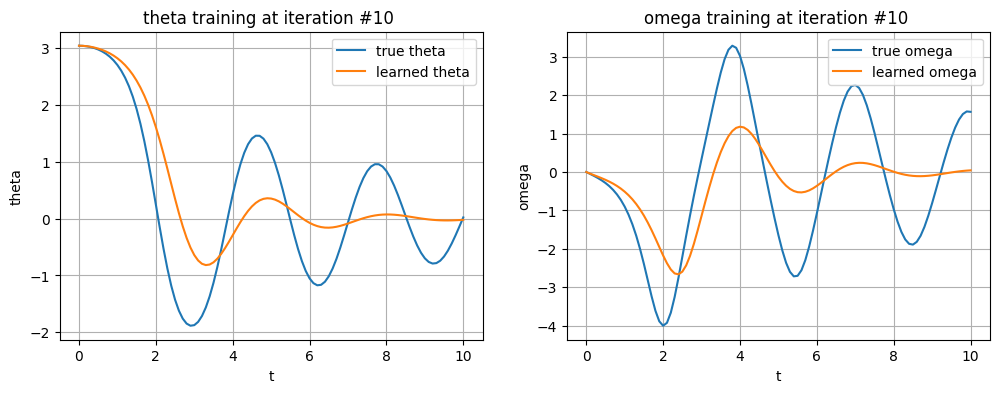

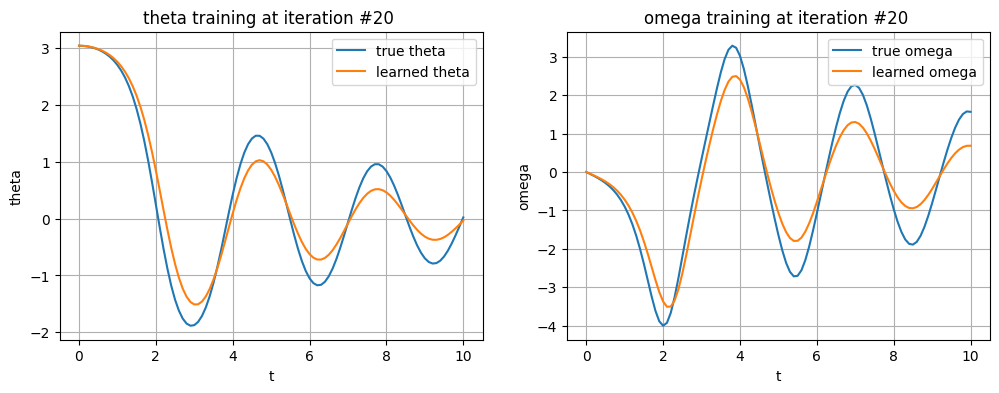

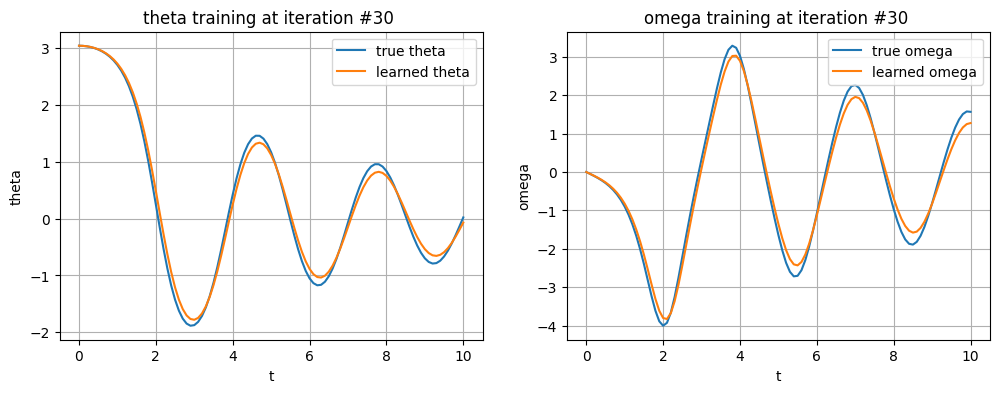

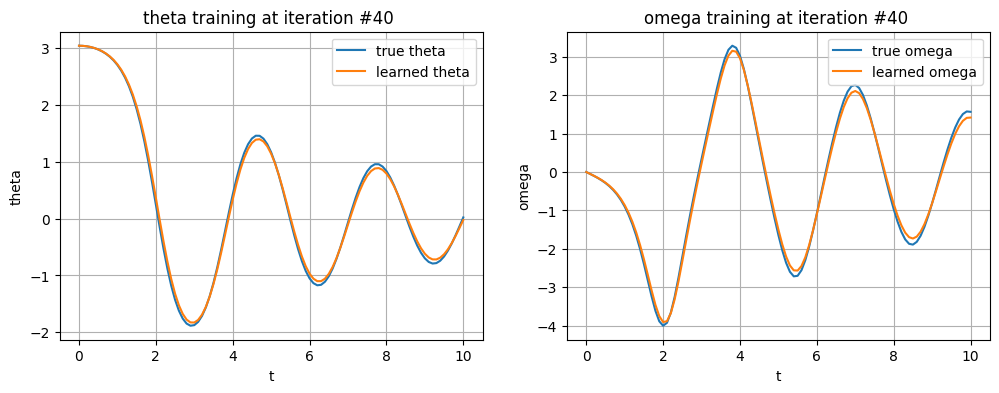

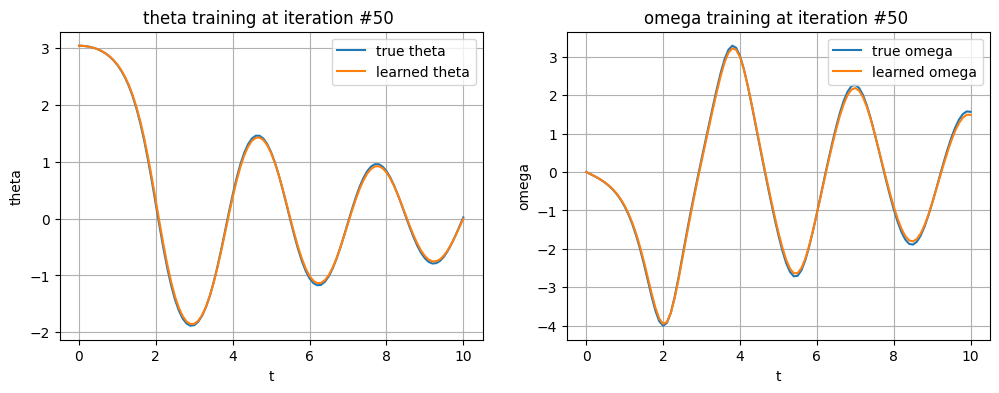

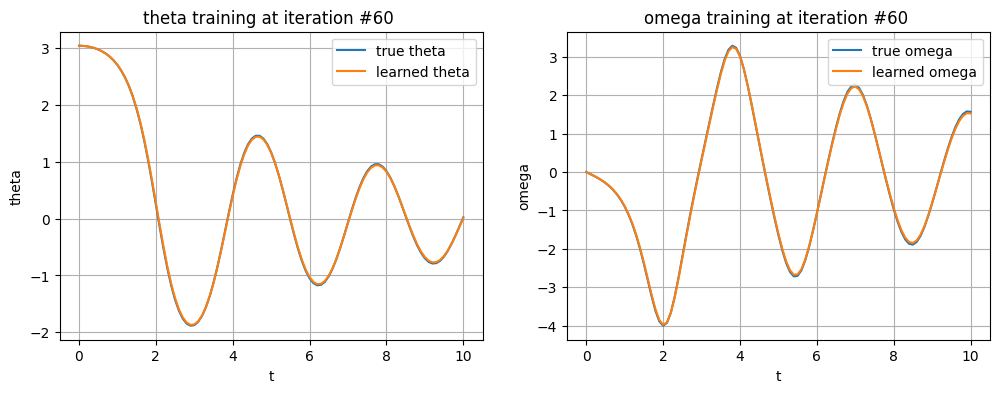

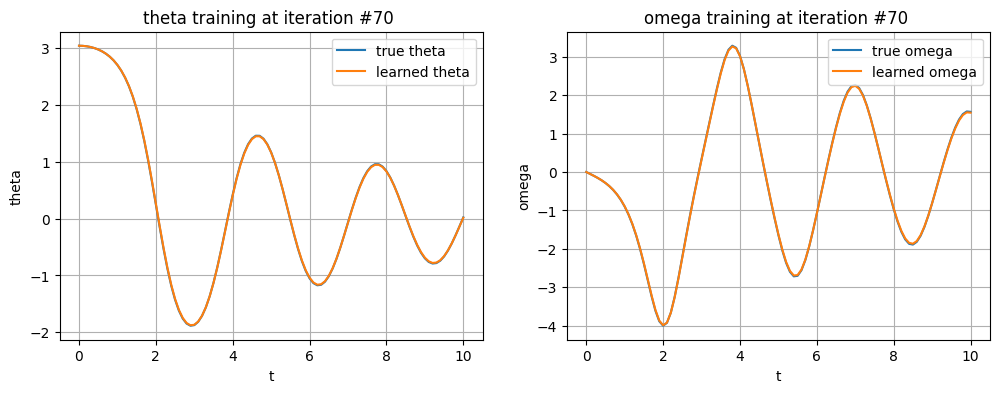

training ended at 77 iteration
learned b: 0.25199809670448303 	 true b: 0.25
learned c: 4.990041255950928 	 true c: 5.0


In [ ]:
## Pendulum
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
import jax.numpy as np
'''
theta''(t) + b*theta'(t) + c*sin(theta(t)) = 0
theta'(t) = omega(t)
omega'(t) = -b*omega(t) - c*sin(theta(t))
'''

def pendulum(y, t, b, c):
    theta, omega = y
    dydt = np.array([omega, -b*omega - c*np.sin(theta)])
    return dydt
#built = build_odeint(pendulum)

# generate ground truth trajectory
y0 = np.array((np.pi - 0.1, 0.0)) # I.C.
t = np.linspace(0., 10., 101)
b = 0.25
c = 5.0
true_traj = odeint(pendulum, y0, t, b, c)
# above this line=evil math professor

# find parameter b and c with JAX
b_guess = 1.5
c_guess = 4.


def loss(b, c):
    return np.sum((odeint(pendulum, y0, t, b, c) - true_traj)**2)
#odeint(Newton, y0, t, a).reshape(-1)
grad_b = jit(grad(loss, 0))
grad_c = jit(grad(loss, 1))



learning_rate = 0.0002
epochs = 1000  #
tol = 1e-2
for epoch in range(epochs):
    b_guess -= learning_rate * grad_b(b_guess,c_guess)
    c_guess -= learning_rate * grad_c(b_guess,c_guess)

    # check how learned ODE fares aginst the real trajectory
    if (epoch+1) % 10 == 0:
        cur_traj = odeint(pendulum, y0, t, b_guess, c_guess)
        fig, ax = plt.subplots(1,2, figsize=(12,4))
        for i, variable in enumerate(['theta', 'omega']):
            ax[i].plot(t, true_traj[:, i], label=f'true {variable}')
            ax[i].plot(t, cur_traj[:, i], label=f'learned {variable}')
            ax[i].set_xlabel('t')
            ax[i].set_ylabel(f'{variable}')
            ax[i].set_title(f'{variable} training at iteration #{epoch+1} ')
            ax[i].grid()
            ax[i].legend()
        plt.show()

    # break condition
    if np.abs(b-b_guess) < tol and np.abs(c-c_guess) < tol:
        print(f'training ended at {epoch+1} iteration')
        print(f'learned b: {b_guess} \t true b: {b}')
        print(f'learned c: {c_guess} \t true c: {c}')
        break

Voila! The integrated trajectories converge toward the ground truth trajectories as training proresses.

## Lorenz Equations

Can we find the parameters of a chaotic system?

learned rho: 15.79137897491455 	 true b: 28
learned sigma: 8.924690246582031 	 true c: 10


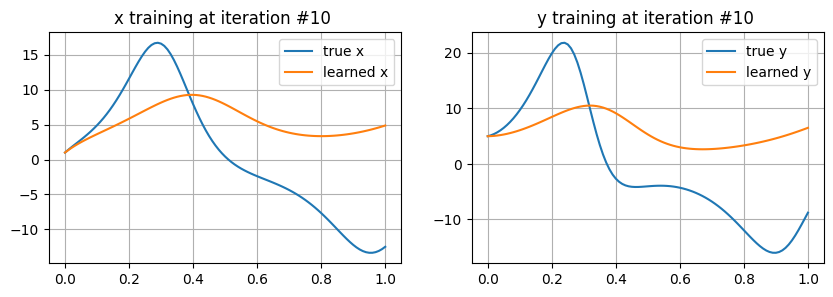

learned rho: 20.80699920654297 	 true b: 28
learned sigma: 9.725378036499023 	 true c: 10


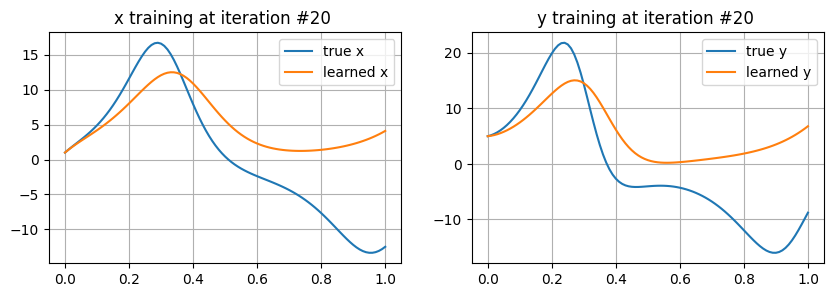

learned rho: 27.45870590209961 	 true b: 28
learned sigma: 10.790844917297363 	 true c: 10


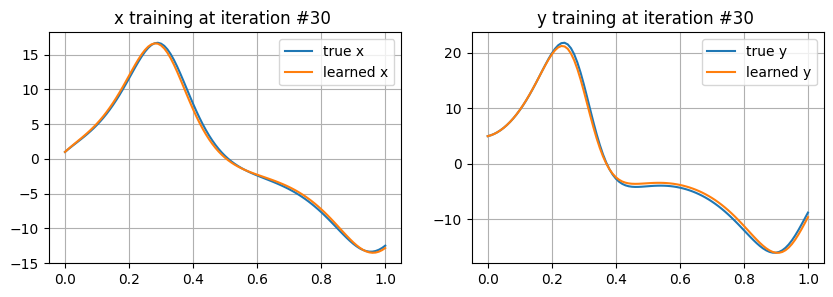

learned rho: 27.769441604614258 	 true b: 28
learned sigma: 10.580904006958008 	 true c: 10


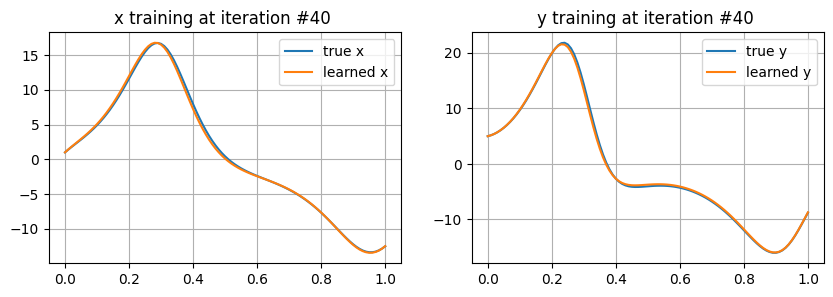

learned rho: 27.83791160583496 	 true b: 28
learned sigma: 10.398324966430664 	 true c: 10


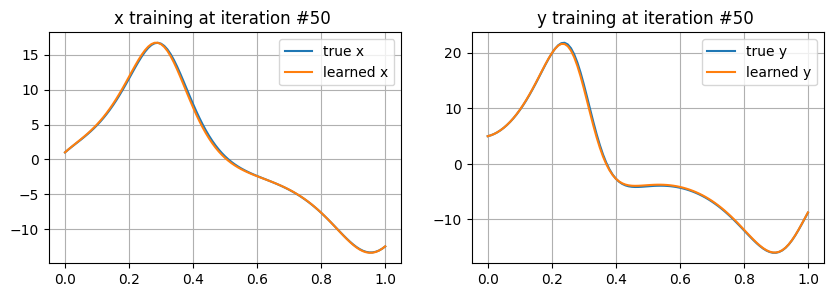

learned rho: 27.88658905029297 	 true b: 28
learned sigma: 10.270781517028809 	 true c: 10


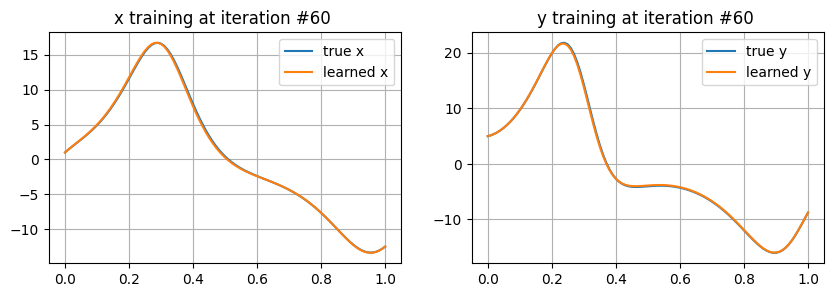

learned rho: 27.921716690063477 	 true b: 28
learned sigma: 10.183160781860352 	 true c: 10


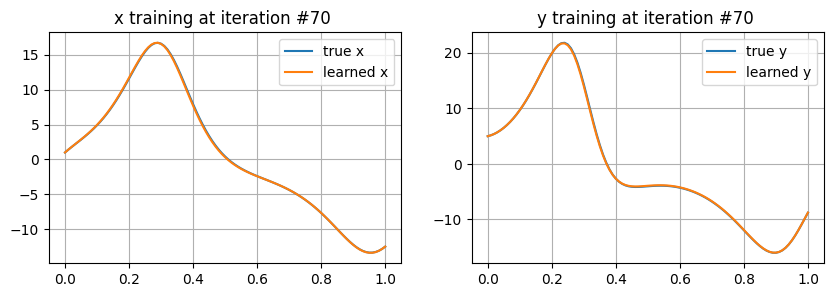

learned rho: 27.94647979736328 	 true b: 28
learned sigma: 10.123483657836914 	 true c: 10


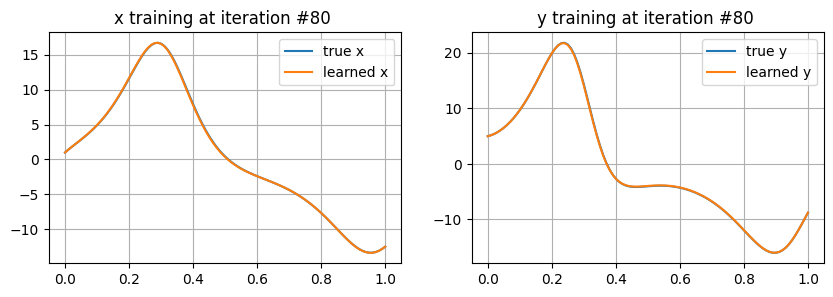

training ended at 86 iteration
learned rho: 27.95754051208496 	 true b: 28
learned sigma: 10.097360610961914 	 true c: 10


In [ ]:
## Lorenz Equations
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt

'''
dx/dt = sigma(y-x)
dy/dt = x(rho - z) - y
dz/dt = xy - beta z
sigma=10, beta = 8/3, rho=28 typical parameters
'''

def lorenz(y_full, t, rho,sigma):
    x,y,z= y_full

    beta=8/3.
    dydt = np.array([sigma*(y-x), x*(rho-z)-y, x*y - beta*z])
    return dydt


# generate ground truth trajectory
y0 = np.array((1.0, 5.0,10.0)) # I.C.
t = np.linspace(0., 1., 101)
rho=28
sigma=10
true_traj = odeint(lorenz, y0, t, rho,sigma)



# find parameter b and c with JAX
rho_guess = 10.
sigma_guess = 8.


def residual(rho, sigma):
    return np.sum((odeint(lorenz,y0, t, rho, sigma) - true_traj)**2)


grad_rho = jit(grad(residual, 0))
grad_sigma = jit(grad(residual, 1))

learning_rate = 0.0002
epochs = 100  #
tol = 1e-1
for epoch in range(epochs):
    rho_guess -= learning_rate * grad_rho(rho_guess,sigma_guess)
    sigma_guess -= learning_rate * grad_sigma(rho_guess,sigma_guess)

    # check how learned ODE fares aginst the real trajectory
    if (epoch+1) % 10 == 0:
        cur_traj = odeint(lorenz, y0, t, rho_guess, sigma_guess)
        fig, ax = plt.subplots(1,2, figsize=(10,3))
        print(f'learned rho: {rho_guess} \t true b: {rho}')
        print(f'learned sigma: {sigma_guess} \t true c: {sigma}')
        for i, variable in enumerate(['x', 'y']):
            ax[i].plot(t, true_traj[:, i], label=f'true {variable}')
            ax[i].plot(t, cur_traj[:, i], label=f'learned {variable}')
            ax[i].set_title(f'{variable} training at iteration #{epoch+1} ')
            ax[i].grid()
            ax[i].legend()
        plt.show()

    # break condition
    if np.abs(rho-rho_guess) < tol and np.abs(sigma-sigma_guess) < tol:
        print(f'training ended at {epoch+1} iteration')
        print(f'learned rho: {rho_guess} \t true b: {rho}')
        print(f'learned sigma: {sigma_guess} \t true c: {sigma}')
        break

# Keller model simulation and optimization

This part is based on Keller's model of optimal racing strategy. In stead of using dynamic programming to solve the optimization problem we will use gradient descent as in the simpler previous examples.

Three main things to notice:
- We have to introduce an explicit parametrization for P(t) for this method to work (we are trying to learn the parameters of P(t) after all).
- Inequality constraints must be included in the loss as very high penalties. While this often work in practice, it is important to notice that it's not mathematically equivalent to enforcing hard constraints as in the original model.
- In this case we have to normalize the gradients in order for the optimization to work correctly, otherwise we rapidly incur in exploding/vanishing gradient problems. This is just an optimization "trick" and does not derive from any formal mathematical consideration.

In [ ]:
from collections import namedtuple

# Model parameters
P_max = 12.0 # m/s^2
k = 1.1 # 1/s
E0 = 2400.0 # m^2/s^2 or J/kg
sigma = 40.0 # m^2/s^3 or W/kg

#container for fixed physiology parameters
PhysiologyParams = namedtuple('PhysiologyParams', ['P_max','k','E0','sigma'])
phys_params = PhysiologyParams(P_max,k,E0,sigma)

In [ ]:
# come up with another reasonable parametrization ?
def polynomial_P(P_max, deg=4):

    n_terms = int(deg+1)

    P_params = np.zeros(n_terms)

    def P(t, P_params):
        t_pow = t ** np.arange(n_terms)
        P = P_max * jax.nn.sigmoid(P_params @ t_pow)
        return P

    return P_params, P

In [ ]:
P_params, P_func = polynomial_P(phys_params.P_max, deg=5)

init_state = np.asarray([0., 0., phys_params.E0])

In [ ]:
init_state

Array([   0.,    0., 2400.], dtype=float32)

In [ ]:
def simulate_keller(state, P_func, P_params, phys_params, dt=.1, T=10):

    def keller_dt(Pt, state):

        x,v,E = state

        dxdt = v
        dvdt = Pt - phys_params.k * v
        dEdt = phys_params.sigma - Pt * v

        return np.asarray([dxdt, dvdt, dEdt])


    ts = np.arange(0,T,dt)

    P_t = np.zeros(len(ts))
    state_t = np.zeros((len(ts),3))

    P = P_func(0, P_params)

    i = 0

    P_t = P_t.at[i].set(P)
    state_t = state_t.at[i].set(state)

    for t in ts[1:]:

        #integration with simple euler scheme
        state = state + keller_dt(P, state) * dt

        #update power
        P = P_func(t, P_params)

        i += 1
        P_t = P_t.at[i].set(P)
        state_t = state_t.at[i].set(state)

    return state_t, P_t

In [ ]:
state_t, P_t = simulate_keller(init_state, P_func, P_params, phys_params, dt=.1, T=10)

## Loss

In [ ]:
def loss_fn(P_params, init_state, P_func, phys_params, dt=.1, T=10, lambda_Emin=3., lambda_Emax=3.):

    state_t, _ = simulate_keller(init_state, P_func, P_params, phys_params, dt, T)

    Et = state_t[:,2]

    # E violates E > 0
    Emin = np.where(Et > 0, 0, -Et).sum()

    # E violates E < E0 (with small tolerance)
    Emax = np.where(Et < phys_params.E0+5, 0, (Et-phys_params.E0)).sum()

    # print(Et)

    return -state_t[-1,0] + lambda_Emin*Emin + lambda_Emax*Emax

## Vanilla SGD (not so good)

We use here a basic handmade implementation of gradient descent. It works decently but as we will see more sophisticated algorithms (like Adam) often ensure faster convergence to better solutions.

In [ ]:
EPOCHS = 100
LEARNING_RATE = 1e-1
T = 10

opt_params = P_params.copy()

loss, loss_grad = jax.value_and_grad(loss_fn)(opt_params, init_state, P_func, phys_params, T=T)
loss_grad = loss_grad / np.sqrt((loss_grad ** 2).sum())

losses = [float(loss)]
params = [opt_params]

pbar = trange(EPOCHS)
for e in pbar:

    # print(loss_grad)

    opt_params = opt_params - LEARNING_RATE * loss_grad

    loss, loss_grad = jax.value_and_grad(loss_fn)(opt_params, init_state, P_func, phys_params, T=T)
    loss_grad = loss_grad / np.sqrt((loss_grad ** 2).sum())


    losses += [float(loss)]
    params += [opt_params]

    pbar.set_description(f'Loss:\t{loss:.2f}')

In [ ]:
plt.plot(losses,'r');

# plt.yscale('log');

In [ ]:
loss_grad

In [ ]:
state_t, P_t = simulate_keller(init_state, P_func, opt_params, phys_params, T=T)

print(f'Final distance in {T:.2f}s:\t{float(state_t[-1,0]):.2f}m')

## Adam (optax library)

We will use the pre-implemented version of the famous Adam algorithm from the `optax` library.

In [ ]:
import optax
from tqdm import trange #range function with progress bar

In [ ]:
EPOCHS = 50
LEARNING_RATE = 1e-1
T = 10.07

opt_params = P_params.copy()

optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(opt_params)


loss, loss_grad = jax.value_and_grad(loss_fn)(opt_params, init_state, P_func, phys_params, T=T)
loss_grad = loss_grad / np.sqrt((loss_grad ** 2).sum())

losses = [float(loss)]
params = [opt_params]

pbar = trange(EPOCHS)
for e in pbar:

    # print(loss_grad)

    updates, opt_state = optimizer.update(loss_grad, opt_state)
    opt_params = optax.apply_updates(opt_params, updates)

    loss, loss_grad = jax.value_and_grad(loss_fn)(opt_params, init_state, P_func, phys_params, T=T)
    loss_grad = loss_grad / np.sqrt((loss_grad ** 2).sum())


    losses += [float(loss)]
    params += [opt_params]

    pbar.set_description(f'Loss:\t{loss:.2f}')

Loss:	6.03: 100%|██████████| 50/50 [03:24<00:00,  4.10s/it]


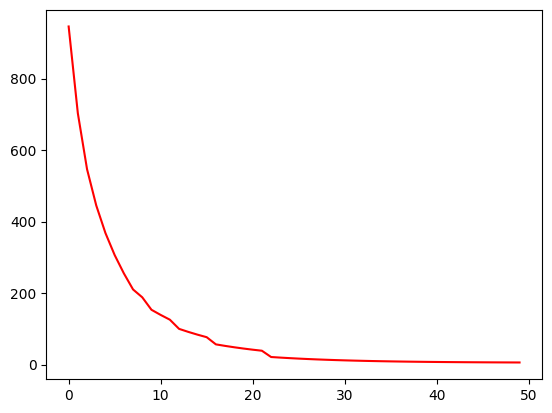

In [ ]:
plt.plot(losses[1:],'r');

In [ ]:
state_t, P_t = simulate_keller(init_state, P_func, opt_params, phys_params, T=T)

print(f'Final distance in {T:.2f}s:\t{float(state_t[-1,0]):.2f}m')

Final distance in 10.07s:	99.16m


In [ ]:
P_t

Array([11.927044, 11.951851, 11.970437, 11.983452, 11.991783, 11.996505,
       11.998783, 11.999672, 11.999935, 11.999991, 12.      , 12.      ,
       12.      , 12.      , 12.      , 12.      , 12.      , 12.      ,
       12.      , 12.      , 12.      , 12.      , 12.      , 12.      ,
       12.      , 12.      , 12.      , 12.      , 12.      , 12.      ,
       12.      , 12.      , 12.      , 12.      , 12.      , 12.      ,
       12.      , 12.      , 12.      , 12.      , 12.      , 12.      ,
       12.      , 12.      , 12.      , 12.      , 12.      , 12.      ,
       12.      , 12.      , 12.      , 12.      , 12.      , 12.      ,
       12.      , 12.      , 12.      , 12.      , 12.      , 12.      ,
       12.      , 12.      , 12.      , 12.      , 12.      , 12.      ,
       12.      , 12.      , 12.      , 12.      , 12.      , 12.      ,
       12.      , 12.      , 12.      , 12.      , 12.      , 12.      ,
       12.      , 12.      , 12.      , 12.      , 

In [ ]:
loss_grad

Array([-0.9939642 , -0.1064349 , -0.025337  , -0.00753598, -0.0026328 ,
       -0.00103266], dtype=float32)

In [ ]:
opt_params

Array([5.106189 , 3.9635532, 2.9743314, 2.238271 , 1.8116733, 1.208384 ],      dtype=float32)